# Download Dataset

**This is a dataset of 50,000 Google Street View Images that gathered from the Google Street View API from 5 cities (San Francisco, Detroit, Chicago, Washington, & New York City).**

In [1]:
!pip install opendatasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/stelath/city-street-view-dataset")

100%|██████████| 7.24G/7.24G [00:47<00:00, 165MB/s]


# Import Packages

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt

In [2]:
input_shape = (128, 128, 3)
batch_size = 32
epochs = 120

# Read Dataset

In [3]:
street_dataset = os.path.join("city-street-view-dataset")

In [4]:
images = list(pathlib.Path(street_dataset).glob("*.jpg"))

In [5]:
len(images)

48953

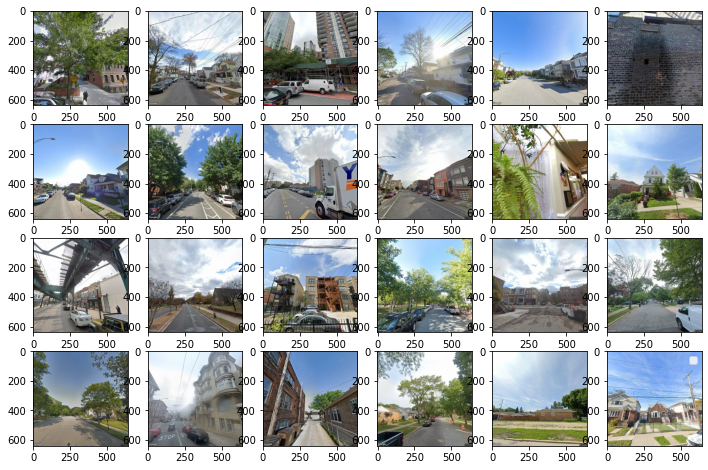

In [6]:
plt.figure(figsize = (12, 8))
for i in range(24):
  plt.subplot(4, 6, (i + 1))
  img = cv2.imread(str(images[i]))
  img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
  plt.imshow(img)
plt.legend()  

*Using a part of Dataset to train a neural network*

In [7]:
images = images[:20000]

In [8]:
len(images)

20000

# Pre-processing dataset images

At this stage, for each image of the dataset, a color copy of the image will be taken, and another copy with gray scales, as the neural network's task will be to reshape the colored image from the grayscale image.

In [9]:
images_rgb = []
images_greyscale = []
for i in range(len(images)):
  img = cv2.imread(str(images[i]))
  img = img/255
  img = cv2.resize(img, (128, 128))
  img = np.float32(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  images_rgb.append(img)
  images_greyscale.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))

In [10]:
images_rgb = np.array(images_rgb)
images_greyscale = np.array(images_greyscale)

In [11]:
images_greyscale.shape

(20000, 128, 128)

In [12]:
images_rgb.shape

(20000, 128, 128, 3)

*View samples of color images and their corresponding grayscale images*

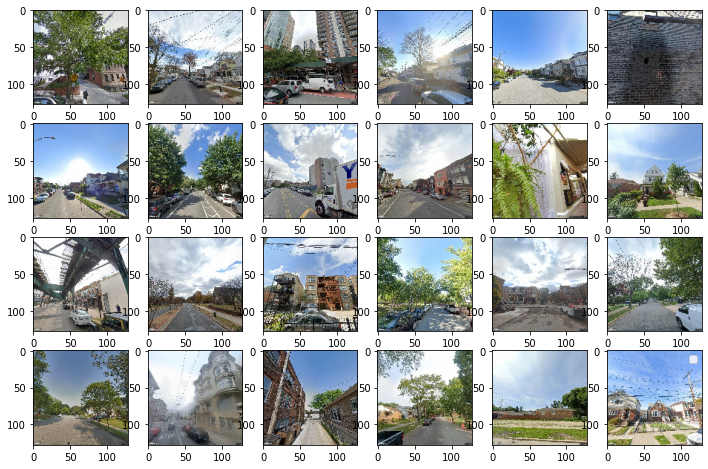

In [13]:
plt.figure(figsize = (12, 8))
for i in range(24):
  plt.subplot(4, 6, (i + 1))
  plt.imshow(images_rgb[i])
plt.legend()  

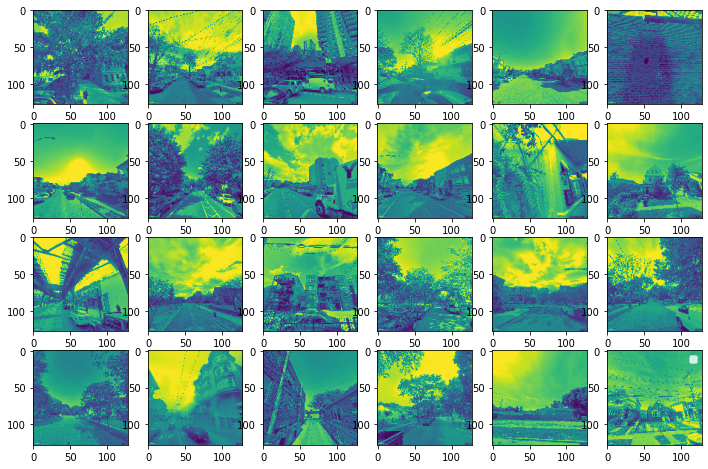

In [14]:
plt.figure(figsize = (12, 8))
for i in range(24):
  plt.subplot(4, 6, (i + 1))
  plt.imshow(images_greyscale[i])
plt.legend()  

# Building a neural network:
**To build the neural network for the encoding process and the decoding process, we need a structure that is able to accurately extract the features from the images and study the relationship between those features. Therefore, I suggested using a structure that is able to pass those features from each stage to the next stage.**

## Encoder Architecture

In [15]:
from keras import backend as k

In [40]:
input_encoder = tf.keras.layers.Input(shape = (128, 128, 1))
filters = [32, 64, 128, 256]
x = tf.keras.layers.Conv2D(filters[0], 3, strides = 2, padding = 'same',
                           activation = 'relu')(input_encoder)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.Conv2D(filters[1], 3, strides = 2, padding = "same",
                           activation = "relu")(x)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.concatenate([y, 
                             tf.keras.layers.Conv2D(filters[1], 1, strides = 2, padding = "same")(x)])
z = tf.keras.layers.Conv2D(filters[2], 3, strides = 2, padding = "same",
                           activation = "relu")(y)
z = tf.keras.layers.Dropout(0.2)(z)
z = tf.keras.layers.BatchNormalization()(z)
z = tf.keras.layers.concatenate([z, 
                             tf.keras.layers.Conv2D(filters[2], 1, strides = 2, padding = "same")(y),
                             tf.keras.layers.Conv2D(filters[2], 1, strides = 4, padding = "same")(x)])
w = tf.keras.layers.Conv2D(filters[3], 3, strides = 2, padding = "same",
                           activation = "relu")(z)
w = tf.keras.layers.Dropout(0.2)(w)
w = tf.keras.layers.BatchNormalization()(w)
w = tf.keras.layers.concatenate([w,
                             tf.keras.layers.Conv2D(filters[3], 1, strides = 2, padding = "same")(z), 
                             tf.keras.layers.Conv2D(filters[3], 1, strides = 4, padding = "same")(y),
                             tf.keras.layers.Conv2D(filters[3], 1, strides = 8, padding = "same")(x)])
encoder_shape = k.int_shape(w)
output = tf.keras.layers.BatchNormalization()(w)
output = tf.keras.layers.Activation("elu")(output)
output = tf.keras.layers.Flatten()(output) 
output = tf.keras.layers.Dense(512)(output)
encoder_model = tf.keras.models.Model(
    input_encoder, output
)
encoder_model.summary()                                                                                                        

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 32)   320         ['input_5[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 64, 64, 32)   0           ['conv2d_20[0][0]']              
                                                                                                  
 batch_normalization_15 (BatchN  (None, 64, 64, 32)  128         ['dropout_12[0][0]']       

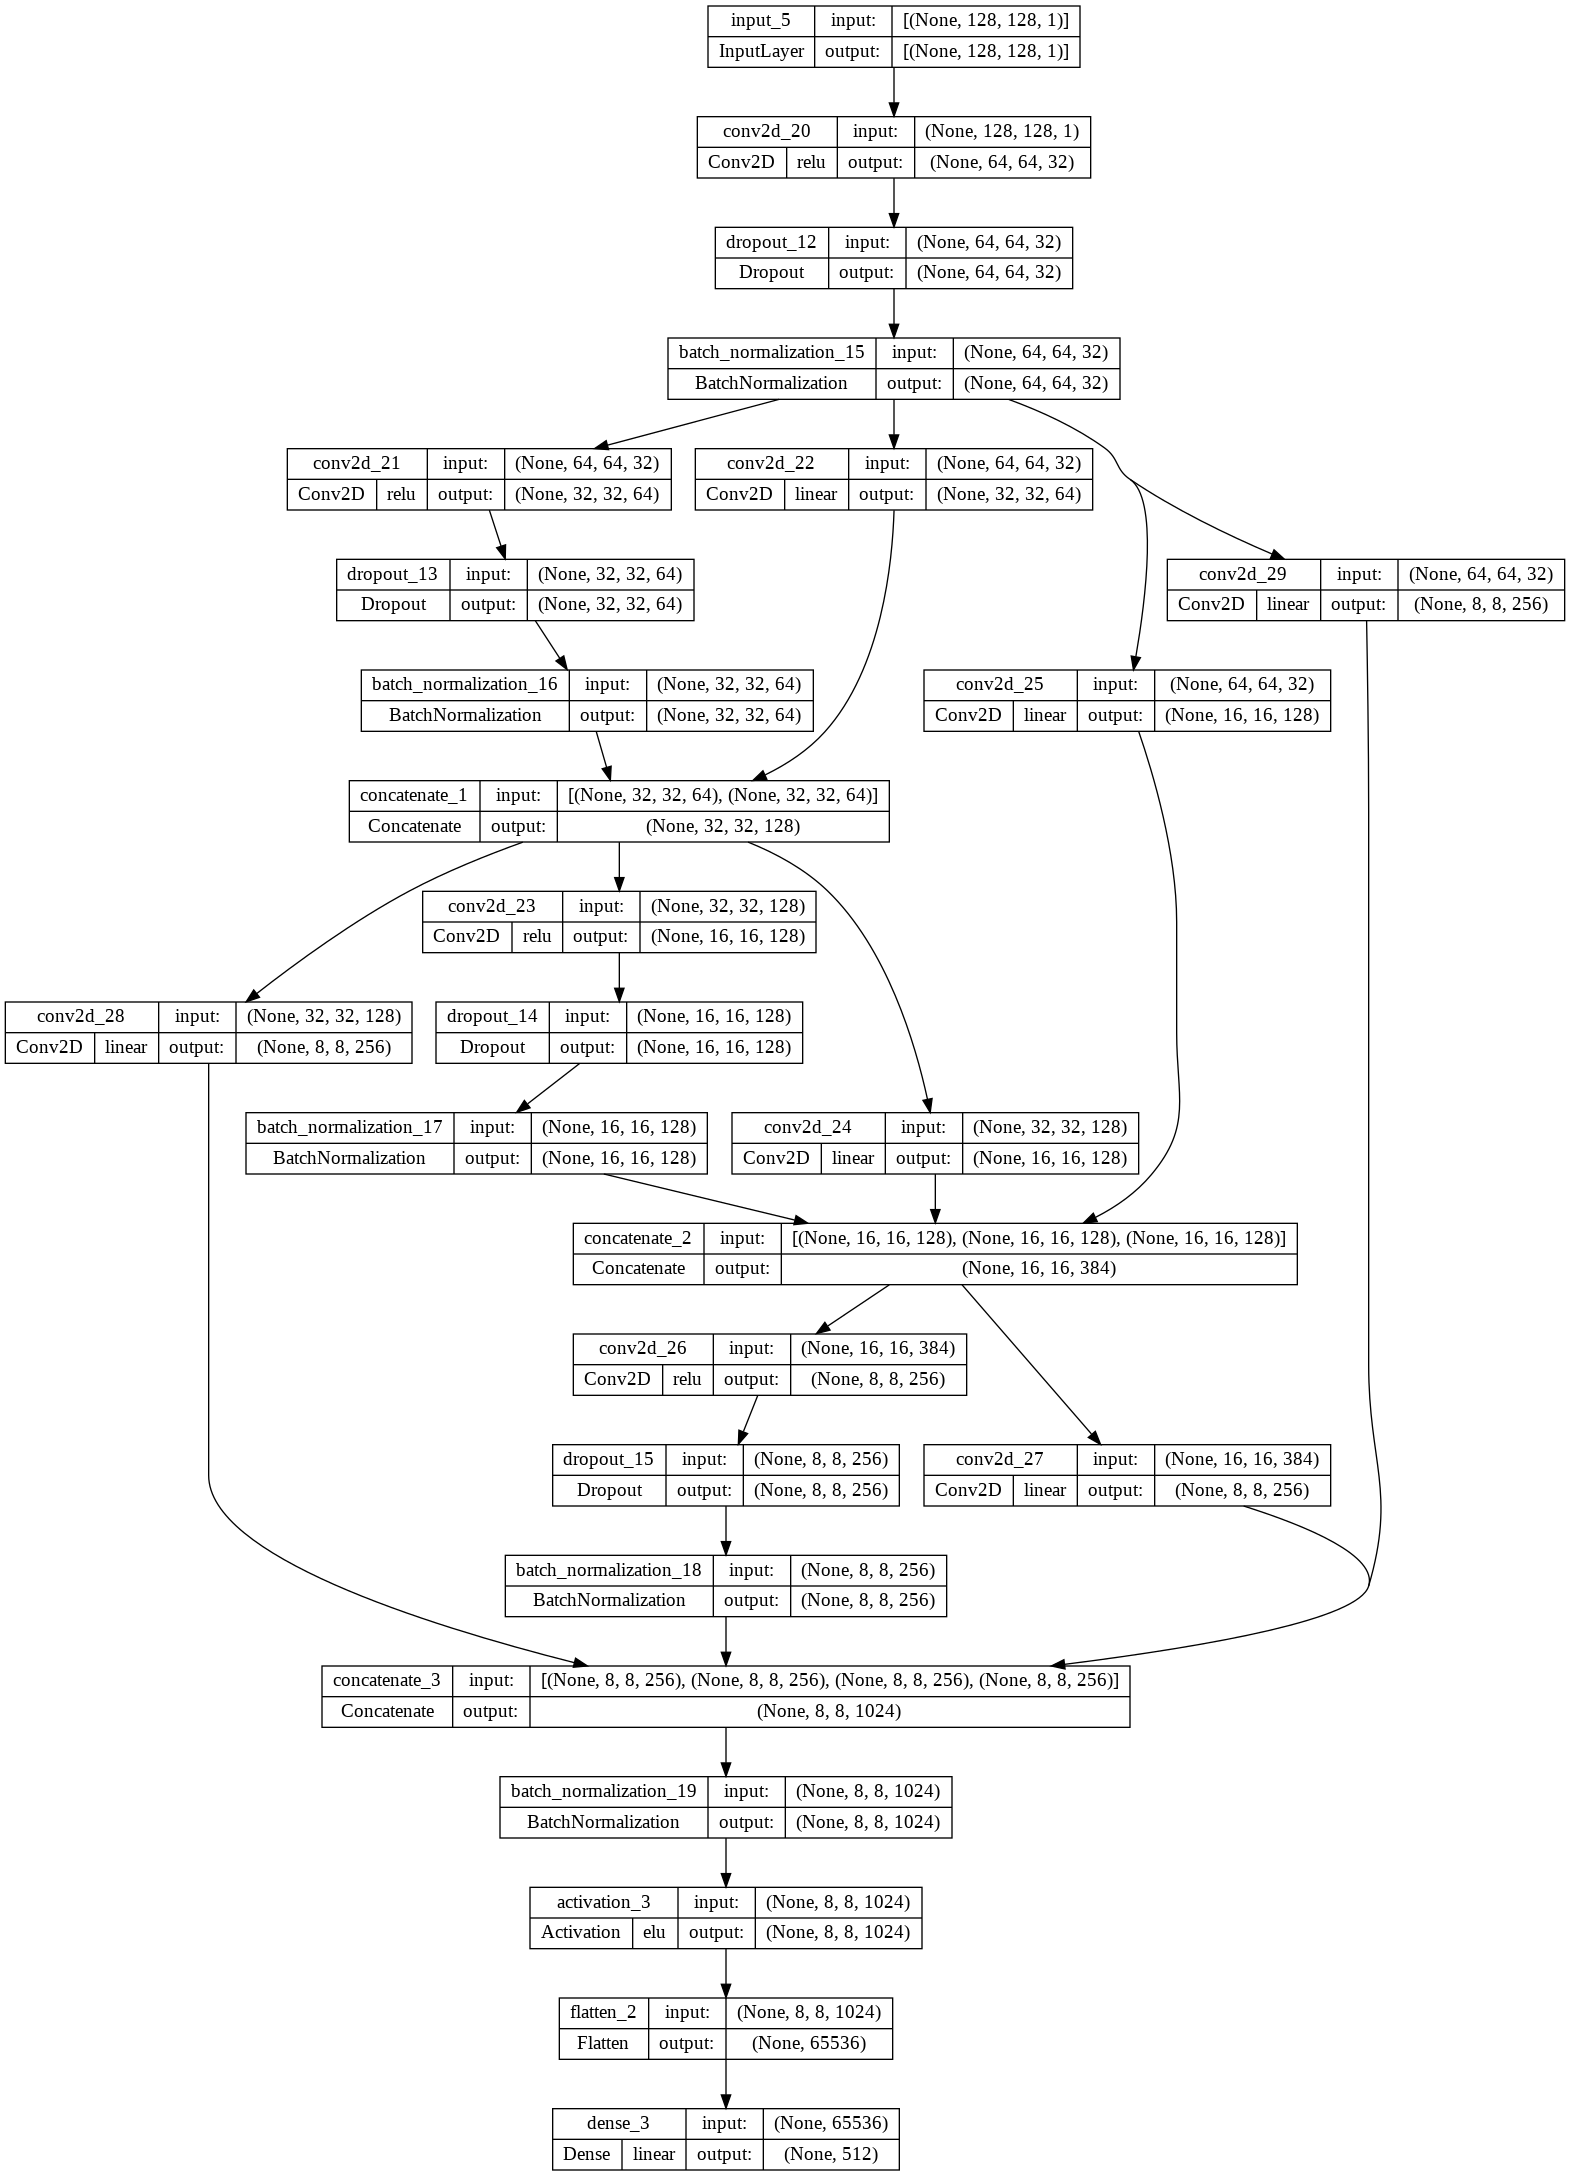

In [41]:
tf.keras.utils.plot_model(encoder_model, show_shapes = True,
                          show_layer_names = True,
                          show_layer_activations = True)

## Decoder Architecture

In [43]:
input_decoder = tf.keras.layers.Input(shape = (512, ))
r = tf.keras.layers.Dense(encoder_shape[1]*encoder_shape[2]*encoder_shape[3])(input_decoder)
r = tf.keras.layers.Reshape((encoder_shape[1], encoder_shape[2], encoder_shape[3]))(r)
filters = [256, 128, 64, 32]
x = tf.keras.layers.Conv2DTranspose(filters[0], 3, strides = 2, padding = 'same',
                           activation = 'elu')(r)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
y = tf.keras.layers.Conv2DTranspose(filters[1], 3, strides = 2, padding = "same",
                           activation = "elu")(x)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.BatchNormalization()(y)
y = tf.keras.layers.concatenate([y, 
                             tf.keras.layers.Conv2DTranspose(filters[1], 1, strides = 2, padding = "same")(x)])
z = tf.keras.layers.Conv2DTranspose(filters[2], 3, strides = 2, padding = "same",
                           activation = "elu")(y)
z = tf.keras.layers.Dropout(0.2)(z)
z = tf.keras.layers.BatchNormalization()(z)
z = tf.keras.layers.concatenate([z, 
                             tf.keras.layers.Conv2DTranspose(filters[2], 1, strides = 2, padding = "same")(y),
                             tf.keras.layers.Conv2DTranspose(filters[2], 1, strides = 4, padding = "same")(x)])
w = tf.keras.layers.Conv2DTranspose(filters[3], 3, strides = 2, padding = "same",
                           activation = "elu")(z)
w = tf.keras.layers.Dropout(0.2)(w)
w = tf.keras.layers.BatchNormalization()(w)
w = tf.keras.layers.concatenate([w,
                             tf.keras.layers.Conv2DTranspose(filters[3], 1, strides = 2, padding = "same")(z), 
                             tf.keras.layers.Conv2DTranspose(filters[3], 1, strides = 4, padding = "same")(y),
                             tf.keras.layers.Conv2DTranspose(filters[3], 1, strides = 8, padding = "same")(x)])
w = tf.keras.layers.BatchNormalization()(w)
w = tf.keras.layers.Conv2DTranspose(3, 3, strides = 1, padding = "same")(w)
output = tf.keras.layers.Activation("sigmoid")(w)
decoder_model = tf.keras.models.Model(
    input_decoder, output
)
decoder_model.summary()                                                                                                        

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 65536)        33619968    ['input_7[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 8, 8, 1024)   0           ['dense_5[0][0]']                
                                                                                                  
 conv2d_transpose_22 (Conv2DTra  (None, 16, 16, 256)  2359552    ['reshape_2[0][0]']              
 nspose)                                                                                    

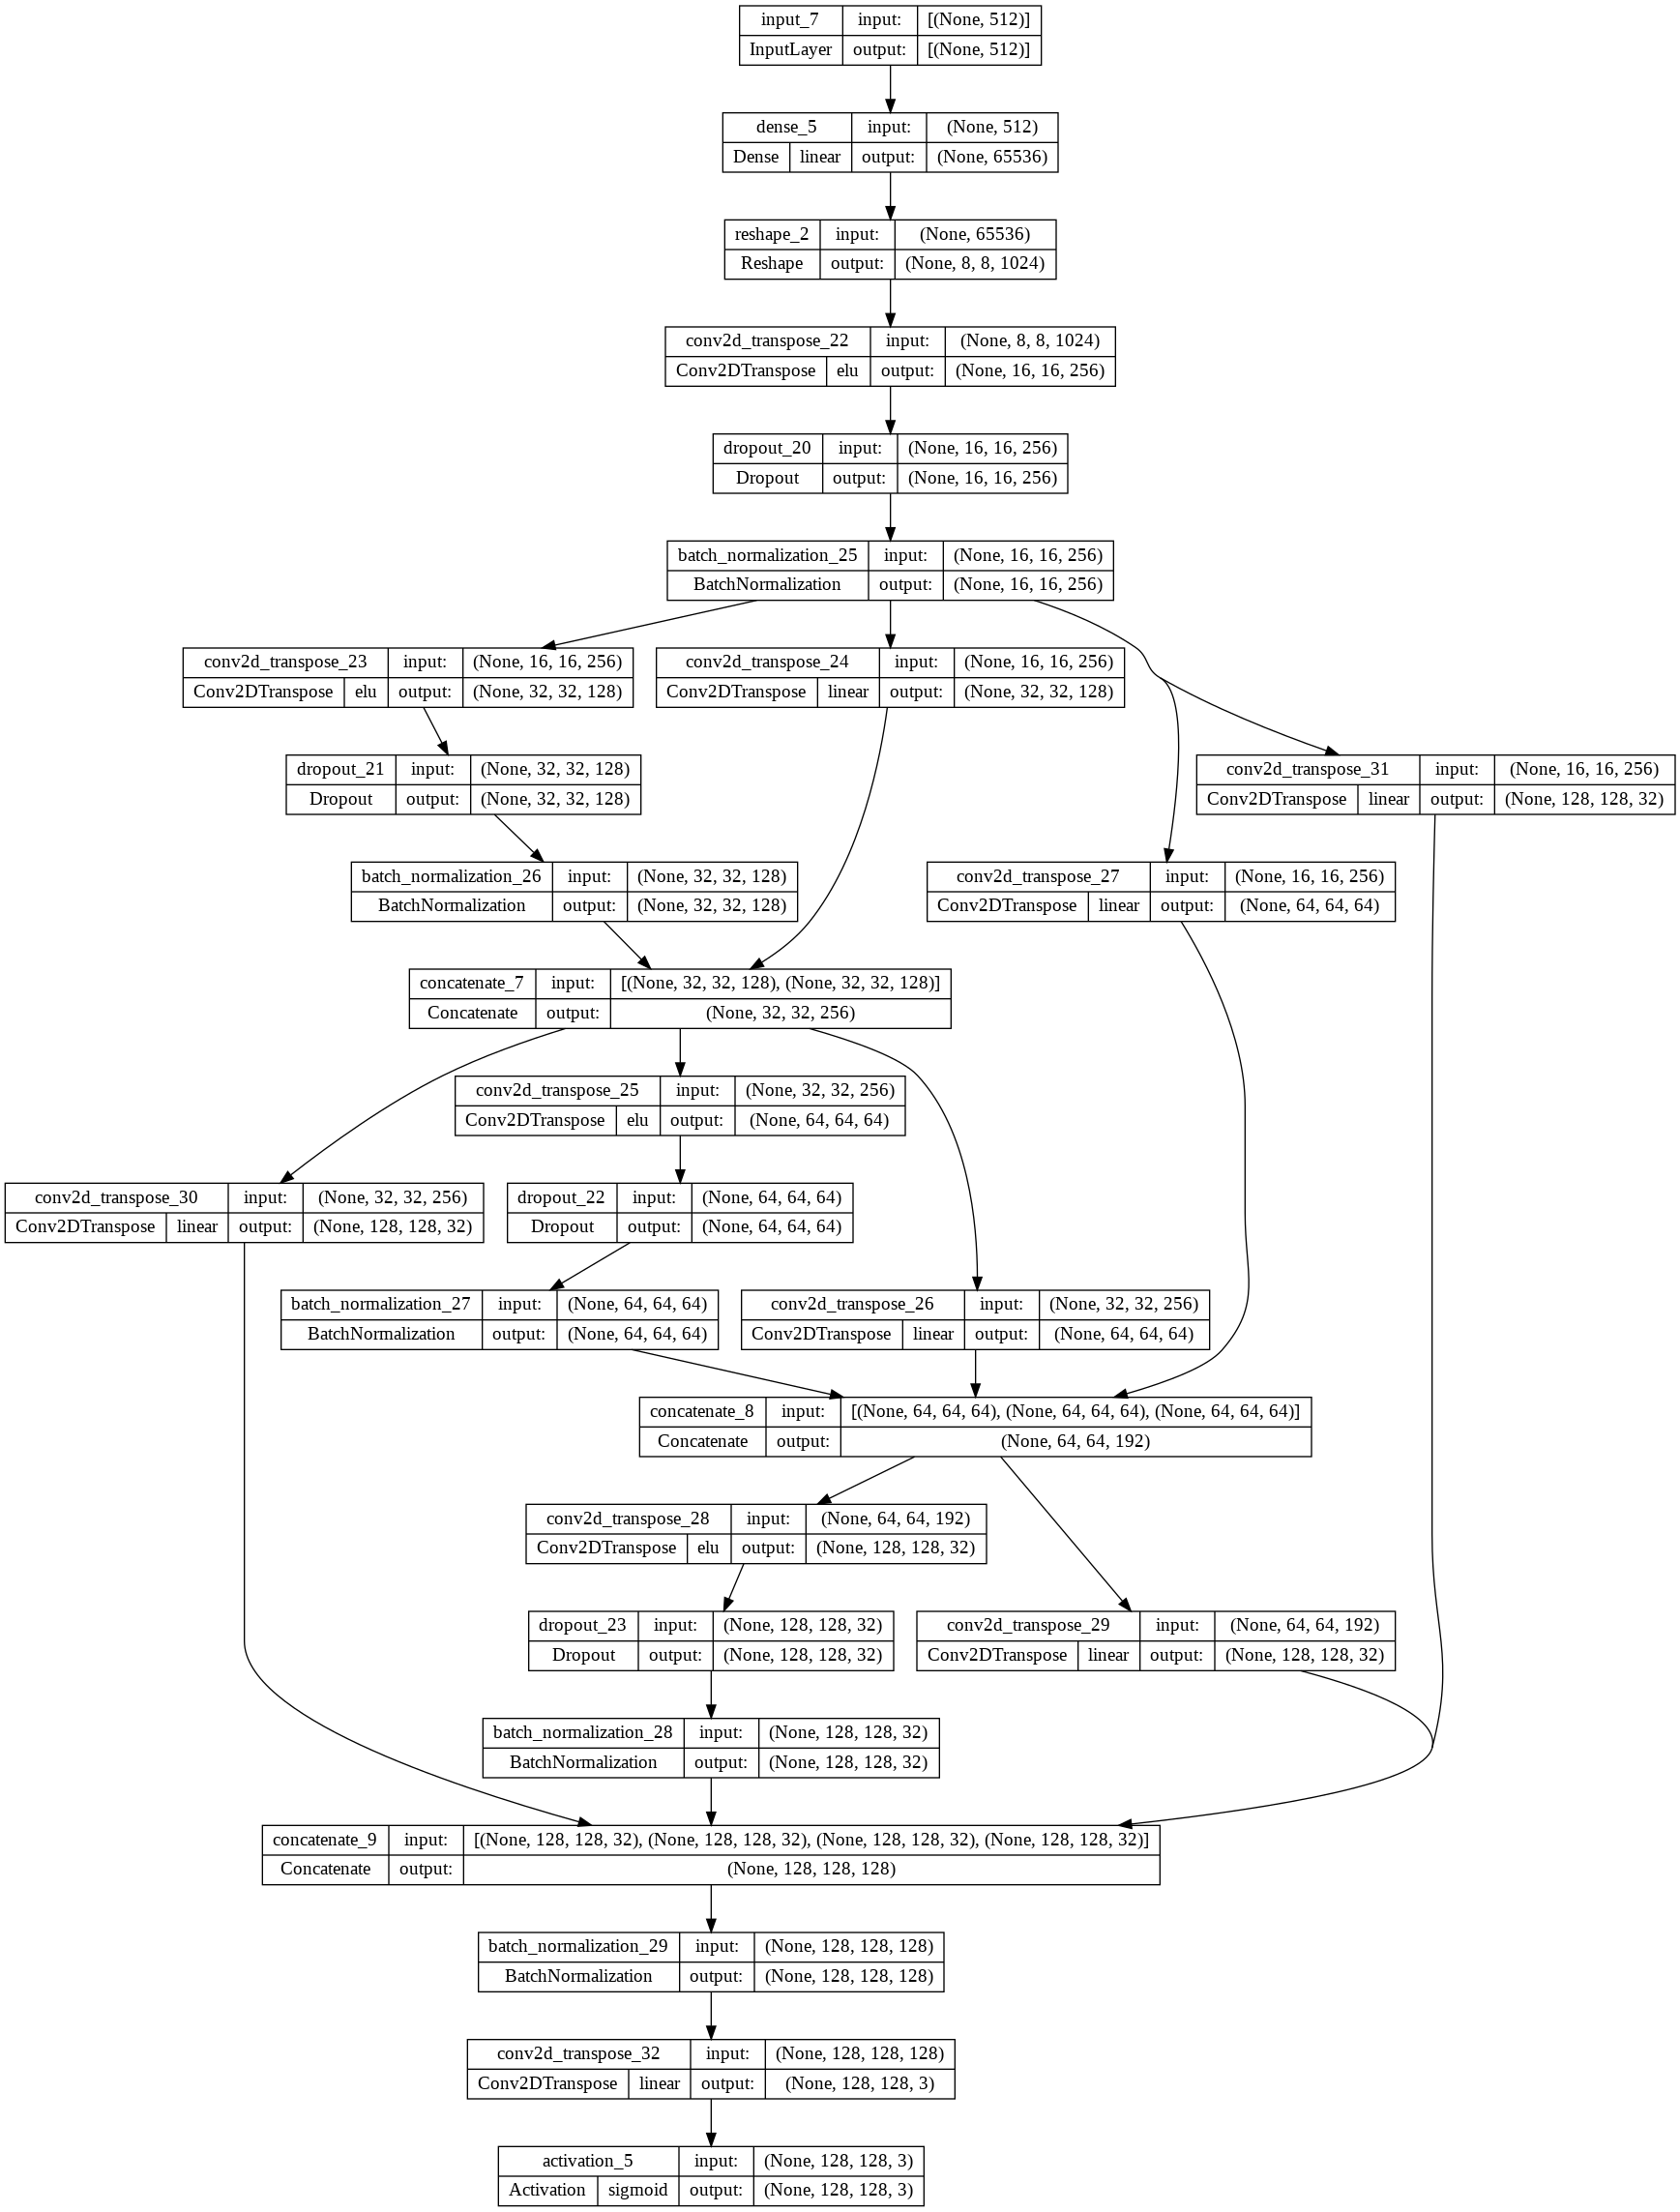

In [44]:
tf.keras.utils.plot_model(decoder_model, show_shapes = True,
                          show_layer_names = True,
                          show_layer_activations = True)

## Acutoencoder Model

In [45]:
input = tf.keras.layers.Input(shape = (128, 128, 1))
autoencoder = tf.keras.models.Model(
    input, decoder_model(encoder_model(input))
)
autoencoder.compile(optimizer = "adam", loss = "mse")
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 model_4 (Functional)        (None, 512)               34775232  
                                                                 
 model_6 (Functional)        (None, 128, 128, 3)       36571715  
                                                                 
Total params: 71,346,947
Trainable params: 71,342,723
Non-trainable params: 4,224
_________________________________________________________________


*Dividing dataset images into a training image and other test images*

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images_greyscale, 
                                                    images_rgb, test_size = 0.2, random_state=True)

## Autoencoder Fit

In [46]:
history = autoencoder.fit(x_train, y_train, epochs = epochs, batch_size = 64,
                          validation_data = (x_test, y_test), 
                          callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min",
                                                                       patience= 3,
                                                                       restore_best_weights=True),
                                       tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", mode = "min",
                                                                            patience = 2, factor=0.1)]
                                )

Epoch 1/120
250/250 [==============================] - 82s 311ms/step - loss: 0.0345 - val_loss: 0.0486 - lr: 0.0010
Epoch 2/120
250/250 [==============================] - 76s 302ms/step - loss: 0.0244 - val_loss: 0.0279 - lr: 0.0010
Epoch 3/120
250/250 [==============================] - 76s 302ms/step - loss: 0.0220 - val_loss: 0.0213 - lr: 0.0010
Epoch 4/120
250/250 [==============================] - 76s 303ms/step - loss: 0.0207 - val_loss: 0.0207 - lr: 0.0010
Epoch 5/120
250/250 [==============================] - 76s 302ms/step - loss: 0.0198 - val_loss: 0.0201 - lr: 0.0010
Epoch 6/120
250/250 [==============================] - 75s 302ms/step - loss: 0.0192 - val_loss: 0.0191 - lr: 0.0010
Epoch 7/120
250/250 [==============================] - 75s 301ms/step - loss: 0.0187 - val_loss: 0.0201 - lr: 0.0010
Epoch 8/120
250/250 [==============================] - 76s 303ms/step - loss: 0.0183 - val_loss: 0.0187 - lr: 0.0010
Epoch 9/120
250/250 [==============================] - 75s 301ms

# Result

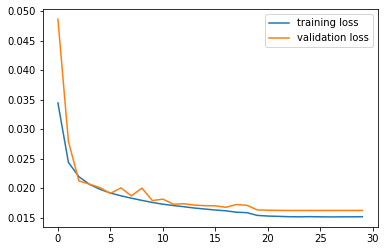

In [47]:
plt.plot(history.history['loss'], label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()

In [48]:
autoencoder.evaluate(x_test, y_test)

125/125 [==============================] - 6s 48ms/step - loss: 0.0163


0.01625051721930504

In [49]:
predict_rgb = autoencoder.predict(x_test)

125/125 [==============================] - 6s 45ms/step


In [50]:
predict_rgb.shape

(4000, 128, 128, 3)

In [52]:
def draw_sample_colorize(x_test, y_test, predict_rgb):
  indexs = np.random.choice(range(4000), 27)
  all_images = []
  for i in indexs:
    all_images.append(x_test[i])
    all_images.append(y_test[i])
    all_images.append(predict_rgb[i]) 
  plt.figure(figsize = (7, 12))
  for i in range(27):
    plt.subplot(9, 3, (i + 1))
    plt.imshow(all_images[i])
  plt.legend()   

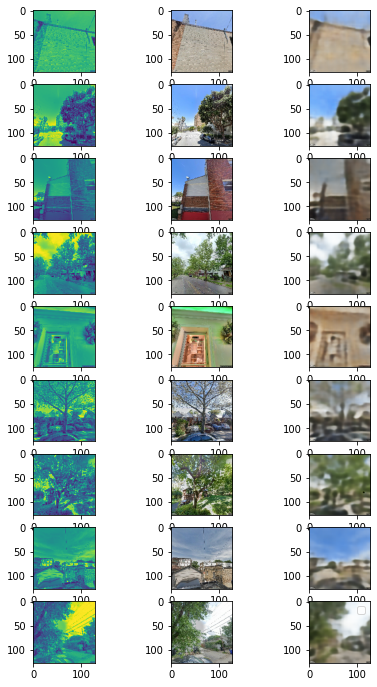

In [53]:
draw_sample_colorize(x_test, y_test, predict_rgb)

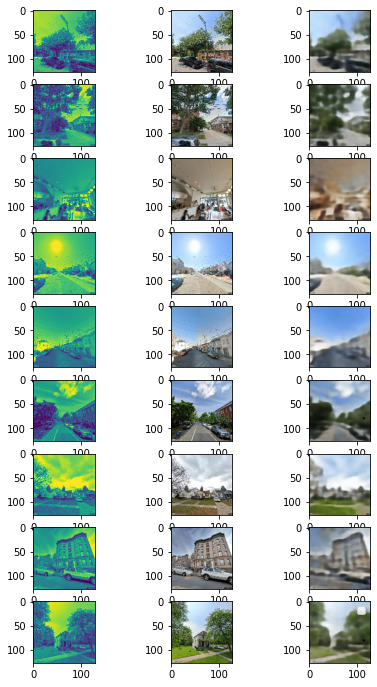

In [54]:
draw_sample_colorize(x_test, y_test, predict_rgb)

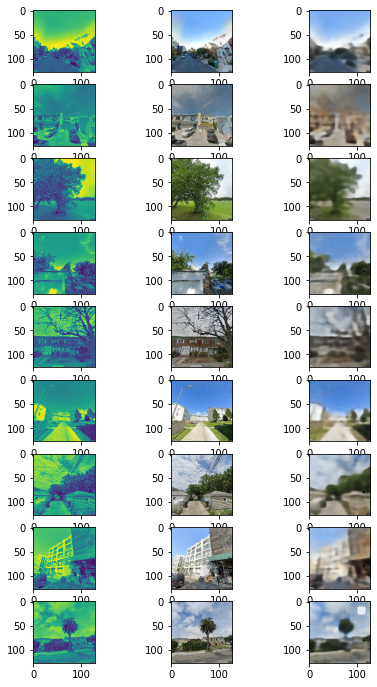

In [56]:
draw_sample_colorize(x_test, y_test, predict_rgb)

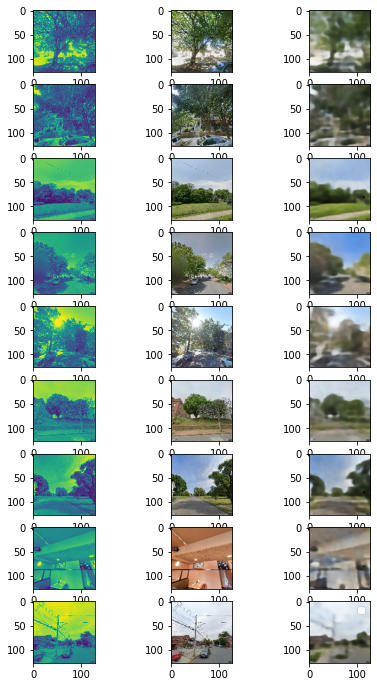

In [60]:
draw_sample_colorize(x_test, y_test, predict_rgb)